## Step 1: Load DAVIS Semantics JSON and Classify Sequences

#### This code loads davis_semantics.json and separates the sequence into two directiories—one for sequences with a single object and one for sequences with multiple objects

In [1]:
import os
import json
import shutil
from pathlib import Path
from config import DATASET_DIR, IMAGE_RESOLUTION

# Define the source directory for the raw annotations (masks)
annotations_src = Path(DATASET_DIR) / "Annotations" / IMAGE_RESOLUTION

# Define output directories for the extracted sequences
output_single = Path("output") / "single_object_annotations"
output_multi = Path("output") / "multi_object_annotations"

# Create the output directories if they do not exist
output_single.mkdir(parents=True, exist_ok=True)
output_multi.mkdir(parents=True, exist_ok=True)

# Load the davis_semantics.json file to classify sequences
semantics_path = Path(DATASET_DIR) / "davis_semantics.json"
with open(semantics_path, 'r') as f:
    semantics = json.load(f)

# Classify sequences into single-object and multi-object lists
single_object_sequences = []
multi_object_sequences = []

for seq, obj_dict in semantics.items():
    if len(obj_dict.keys()) == 1:
        single_object_sequences.append(seq)
    else:
        multi_object_sequences.append(seq)

print("Single-object sequences:", single_object_sequences)
print("Multi-object sequences:", multi_object_sequences)

# Define a function to copy a sequence folder from the annotations source to the destination folder
def copy_sequence(seq_name, dest_folder):
    src_path = annotations_src / seq_name
    if src_path.exists() and src_path.is_dir():
        dest_path = dest_folder / seq_name
        # If the destination already exists, remove it first
        if dest_path.exists():
            shutil.rmtree(dest_path)
        shutil.copytree(src_path, dest_path)
        print(f"Copied sequence '{seq_name}' to {dest_path}")
    else:
        print(f"Sequence folder '{seq_name}' not found at {src_path}")

# Copy single-object sequences from Annotations to 'multi_object_masks' folder
for seq in single_object_sequences:
    copy_sequence(seq, output_single)

# Copy multi-object sequences from Annotations to 'multi_object_masks' folder
for seq in multi_object_sequences:
    copy_sequence(seq, output_multi)

Single-object sequences: ['bear', 'blackswan', 'boat', 'breakdance', 'breakdance-flare', 'burnout', 'bus', 'camel', 'car-roundabout', 'car-shadow', 'car-turn', 'chamaleon', 'cows', 'dance-jump', 'dance-twirl', 'dive-in', 'dog', 'dog-agility', 'drift-chicane', 'drift-straight', 'drift-turn', 'elephant', 'flamingo', 'goat', 'hike', 'koala', 'libby', 'lucia', 'mallard-fly', 'mallard-water', 'parkour', 'rallye', 'rhino', 'rollerblade', 'rollercoaster', 'seasnake', 'slackline', 'soccerball', 'turtle', 'varanus-cage']
Multi-object sequences: ['aerobatics', 'bike-packing', 'bike-trial', 'bmx-bumps', 'bmx-trees', 'boxing', 'boxing-fisheye', 'car-race', 'carousel', 'cat-girl', 'cats-car', 'choreography', 'classic-car', 'color-run', 'crossing', 'dancing', 'deer', 'demolition', 'disc-jockey', 'dog-control', 'dog-gooses', 'dogs-jump', 'dogs-scale', 'dolphins', 'drone', 'e-bike', 'giant-slalom', 'girl-dog', 'gold-fish', 'golf', 'grass-chopper', 'guitar-violin', 'gym', 'helicopter', 'hockey', 'horse

#### Checking whether all sequences from annotations are stored accordingly into the separate directories

In [2]:
import os
import json
from pathlib import Path
from config import DATASET_DIR, IMAGE_RESOLUTION

# Step 1: List all sequence names from the Annotations directory.
annotations_dir = Path(DATASET_DIR) / "Annotations" / IMAGE_RESOLUTION
all_sequences = [folder.name for folder in annotations_dir.iterdir() if folder.is_dir()]

print("All sequences from Annotations:", all_sequences)
print("Total sequences:", len(all_sequences))

# Step 2: Load the semantics JSON file.
semantics_path = Path(DATASET_DIR) / "davis_semantics.json"
with open(semantics_path, 'r') as f:
    semantics = json.load(f)

# Step 3: Classify sequences into single-object and multi-object based on the semantics JSON.
single_object_sequences = []
multi_object_sequences = []

for seq in all_sequences:
    if seq in semantics:
        # Use the semantics info only for sequences that are present in your Annotations folder.
        if len(semantics[seq].keys()) == 1:
            single_object_sequences.append(seq)
        elif len(semantics[seq].keys()) > 1:
            multi_object_sequences.append(seq)
    else:
        print(f"Sequence '{seq}' is not found in the semantics JSON; skipping classification for this sequence.")

# Print out the lists and counts.
print("\nSingle-object sequences:", single_object_sequences)
print("Count of single-object sequences:", len(single_object_sequences))

print("\nMulti-object sequences:", multi_object_sequences)
print("Count of multi-object sequences:", len(multi_object_sequences))

All sequences from Annotations: ['night-race', 'hike', 'mallard-fly', 'upside-down', 'pigs', 'dance-jump', 'dancing', 'mallard-water', 'cows', 'dance-twirl', 'soapbox', 'loading', 'stroller', 'miami-surf', 'schoolgirls', 'dog', 'lucia', 'bike-packing', 'bear', 'horsejump-high', 'sheep', 'swing', 'kite-walk', 'lindy-hop', 'boat', 'tractor-sand', 'rollerblade', 'horsejump-low', 'longboard', 'camel', 'drift-chicane', 'motocross-bumps', 'parkour', 'bus', 'lady-running', 'cat-girl', 'gold-fish', 'walking', 'motorbike', 'goat', 'breakdance', 'drone', 'car-roundabout', 'snowboard', 'scooter-black', 'soccerball', 'scooter-gray', 'drift-turn', 'planes-water', 'breakdance-flare', 'dog-agility', 'dogs-scale', 'libby', 'surf', 'stunt', 'boxing-fisheye', 'scooter-board', 'skate-park', 'hockey', 'disc-jockey', 'drift-straight', 'dog-gooses', 'train', 'india', 'rhino', 'paragliding-launch', 'motocross-jump', 'tennis', 'paragliding', 'koala', 'bmx-trees', 'kite-surf', 'tuk-tuk', 'rallye', 'varanus-cag

### STEP 2: Preprocessing the Single-Object Video Sequences' Frames for Generating Bounding Boxes 

#### PT.1 Deriving Bounding Boxes: Grayscale Covnersion on Single-Object Sequences

In [3]:
import cv2
import os
from pathlib import Path

# Input directory: where your single-object masked frames are stored.
input_dir = Path("output") / "single_object_annotations"
# Output directory for grayscale masks.
output_dir = Path("output") / "grayscale_single_object_masks"

# Create the output directory (and any parent directories) if they don't exist.
output_dir.mkdir(parents=True, exist_ok=True)

# Iterate over each sequence folder within the input directory.
for sequence_folder in input_dir.iterdir():
    if sequence_folder.is_dir():
        # Create a corresponding output folder for the sequence.
        sequence_output = output_dir / sequence_folder.name
        sequence_output.mkdir(parents=True, exist_ok=True)
        
        # Process each image file in the sequence folder.
        for img_file in sequence_folder.iterdir():
            if img_file.suffix.lower() in ['.png', '.jpg', '.jpeg']:
                # Read the mask in color mode.
                mask_color = cv2.imread(str(img_file), cv2.IMREAD_COLOR)
                # Convert the color mask to grayscale.
                mask_gray = cv2.cvtColor(mask_color, cv2.COLOR_BGR2GRAY)
                # Construct the output path.
                output_path = sequence_output / img_file.name
                # Save the grayscale mask.
                cv2.imwrite(str(output_path), mask_gray)
                print(f"Converted {img_file} to grayscale and saved as {output_path}")

Converted output/single_object_annotations/hike/00052.png to grayscale and saved as output/grayscale_single_object_masks/hike/00052.png
Converted output/single_object_annotations/hike/00046.png to grayscale and saved as output/grayscale_single_object_masks/hike/00046.png
Converted output/single_object_annotations/hike/00047.png to grayscale and saved as output/grayscale_single_object_masks/hike/00047.png
Converted output/single_object_annotations/hike/00053.png to grayscale and saved as output/grayscale_single_object_masks/hike/00053.png
Converted output/single_object_annotations/hike/00045.png to grayscale and saved as output/grayscale_single_object_masks/hike/00045.png
Converted output/single_object_annotations/hike/00051.png to grayscale and saved as output/grayscale_single_object_masks/hike/00051.png
Converted output/single_object_annotations/hike/00079.png to grayscale and saved as output/grayscale_single_object_masks/hike/00079.png
Converted output/single_object_annotations/hike/

#### PT.2 Deriving Bounding Boxes: Binary Masks on Grayscaled Single-Object Sequences

In [4]:
# Checking the graysclae value of the masks to choose the threshold at which the mask should become white
import cv2
import numpy as np
from pathlib import Path

# Define the root folder where your grayscale masks are stored.
# Adjust this path if necessary.
grayscale_dir = Path("output") / "grayscale_single_object_masks"

# Iterate over each sequence folder and then over each image file in those folders.
for sequence_folder in grayscale_dir.iterdir():
    if sequence_folder.is_dir():
        print(f"Sequence: {sequence_folder.name}")
        for img_file in sequence_folder.glob("*.*"):
            # Process only image files with common extensions.
            if img_file.suffix.lower() in ['.png', '.jpg', '.jpeg']:
                # Load the mask in grayscale.
                mask = cv2.imread(str(img_file), cv2.IMREAD_GRAYSCALE)
                if mask is None:
                    print(f"  Failed to load: {img_file}")
                    continue
                # Find unique pixel values.
                unique_vals = np.unique(mask)
                print(f"  {img_file.name}: {unique_vals}")

Sequence: hike
  00052.png: [ 0 38]
  00046.png: [ 0 38]
  00047.png: [ 0 38]
  00053.png: [ 0 38]
  00045.png: [ 0 38]
  00051.png: [ 0 38]
  00079.png: [ 0 38]
  00078.png: [ 0 38]
  00050.png: [ 0 38]
  00044.png: [ 0 38]
  00068.png: [ 0 38]
  00040.png: [ 0 38]
  00054.png: [ 0 38]
  00055.png: [ 0 38]
  00041.png: [ 0 38]
  00069.png: [ 0 38]
  00057.png: [ 0 38]
  00043.png: [ 0 38]
  00042.png: [ 0 38]
  00056.png: [ 0 38]
  00031.png: [ 0 38]
  00025.png: [ 0 38]
  00019.png: [ 0 38]
  00018.png: [ 0 38]
  00024.png: [ 0 38]
  00030.png: [ 0 38]
  00026.png: [ 0 38]
  00032.png: [ 0 38]
  00033.png: [ 0 38]
  00027.png: [ 0 38]
  00023.png: [ 0 38]
  00037.png: [ 0 38]
  00036.png: [ 0 38]
  00022.png: [ 0 38]
  00008.png: [ 0 38]
  00034.png: [ 0 38]
  00020.png: [ 0 38]
  00021.png: [ 0 38]
  00035.png: [ 0 38]
  00009.png: [ 0 38]
  00010.png: [ 0 38]
  00004.png: [ 0 38]
  00038.png: [ 0 38]
  00039.png: [ 0 38]
  00005.png: [ 0 38]
  00011.png: [ 0 38]
  00007.png: [ 0 38

In [5]:
# Checking the graysclae value of the mask to choose the threshold at which the mask should become white
from pathlib import Path
import cv2

mask_path = Path("output/grayscale_single_object_masks/dog/00000.png")
grayscale_mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
unique_vals = np.unique(grayscale_mask)
print("Unique pixel values in the grayscale mask:", unique_vals)

Unique pixel values in the grayscale mask: [ 0 38]


Otsu threshold: 0.0


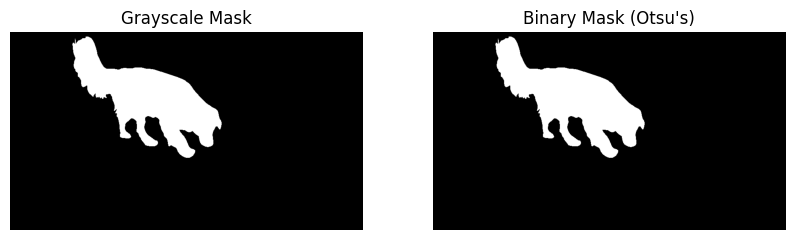

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

def convert_to_binary_mask_otsu(grayscale_mask):
    """
    Applies Otsu's thresholding to a grayscale mask to produce a binary mask.
    """
    # Use Otsu's thresholding: the threshold value is automatically determined.
    ret, binary_mask = cv2.threshold(grayscale_mask, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    print(f"Otsu threshold: {ret}")
    return binary_mask

# Example usage:
mask_path = Path("output/grayscale_single_object_masks/dog/00000.png")
grayscale_mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
binary_mask = convert_to_binary_mask_otsu(grayscale_mask)

plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.imshow(grayscale_mask, cmap='gray')
plt.title("Grayscale Mask")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(binary_mask, cmap='gray')
plt.title("Binary Mask (Otsu's)")
plt.axis('off')

plt.show()

In [7]:
import cv2
import numpy as np
from pathlib import Path

def convert_to_binary_mask_otsu(grayscale_mask):
    """
    Applies Otsu's thresholding to a grayscale mask to produce a binary mask.
    """
    ret, binary_mask = cv2.threshold(grayscale_mask, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    print(f"Otsu threshold: {ret}")
    return binary_mask

def process_and_save_binary_mask(input_mask_path, output_mask_path):
    """
    Loads a grayscale mask, converts it to a binary mask using Otsu's method,
    and saves the binary mask to the output path.
    """
    # Load the grayscale mask
    grayscale_mask = cv2.imread(str(input_mask_path), cv2.IMREAD_GRAYSCALE)
    if grayscale_mask is None:
        raise FileNotFoundError(f"Could not load mask from: {input_mask_path}")
    
    # Convert the mask using Otsu's thresholding
    binary_mask = convert_to_binary_mask_otsu(grayscale_mask)
    
    # Ensure the output directory exists
    output_mask_path.parent.mkdir(parents=True, exist_ok=True)
    
    # Save the binary mask
    cv2.imwrite(str(output_mask_path), binary_mask)
    print(f"Saved binary mask to: {output_mask_path}")

def process_all_single_object_masks(input_root, output_root):
    """
    Processes all single-object mask images found under the input_root directory.
    For each sequence folder, it converts each mask image to binary and saves it in the corresponding folder under output_root.
    """
    input_root = Path(input_root)
    output_root = Path(output_root)
    
    for sequence_folder in input_root.iterdir():
        if sequence_folder.is_dir():
            # Create corresponding output folder for this sequence
            sequence_output = output_root / sequence_folder.name
            sequence_output.mkdir(parents=True, exist_ok=True)
            print(f"Processing sequence: {sequence_folder.name}")
            
            # Process each image file in the sequence folder
            for img_file in sequence_folder.iterdir():
                if img_file.suffix.lower() in ['.png', '.jpg', '.jpeg']:
                    output_path = sequence_output / img_file.name
                    process_and_save_binary_mask(img_file, output_path)

if __name__ == "__main__":
    # Input directory containing your grayscale single-object masks
    input_dir = Path("output") / "grayscale_single_object_masks"
    # Output directory where the binary masks will be saved
    output_dir = Path("output") / "binary_single_object_masks"
    
    process_all_single_object_masks(input_dir, output_dir)

Processing sequence: hike
Otsu threshold: 0.0
Saved binary mask to: output/binary_single_object_masks/hike/00052.png
Otsu threshold: 0.0
Saved binary mask to: output/binary_single_object_masks/hike/00046.png
Otsu threshold: 0.0
Saved binary mask to: output/binary_single_object_masks/hike/00047.png
Otsu threshold: 0.0
Saved binary mask to: output/binary_single_object_masks/hike/00053.png
Otsu threshold: 0.0
Saved binary mask to: output/binary_single_object_masks/hike/00045.png
Otsu threshold: 0.0
Saved binary mask to: output/binary_single_object_masks/hike/00051.png
Otsu threshold: 0.0
Saved binary mask to: output/binary_single_object_masks/hike/00079.png
Otsu threshold: 0.0
Saved binary mask to: output/binary_single_object_masks/hike/00078.png
Otsu threshold: 0.0
Saved binary mask to: output/binary_single_object_masks/hike/00050.png
Otsu threshold: 0.0
Saved binary mask to: output/binary_single_object_masks/hike/00044.png
Otsu threshold: 0.0
Saved binary mask to: output/binary_single_o

### STEP 3: Preprocessing the Multi-Object Video Sequences' Frames for Generating Bounding Boxes 